### Business Underatanding

## Overview

The Connectivity Map, a project within the Broad Institute of MIT and Harvard, the Laboratory for Innovation Science at Harvard (LISH), and the NIH Common Funds Library of Integrated Network-Based Cellular Signatures (LINCS), present this challenge with the goal of advancing drug development through improvements to MoA prediction algorithms.

What is the Mechanism of Action (MoA) of a drug? And why is it important?

In the past, scientists derived drugs from natural products or were inspired by traditional remedies. Very common drugs, such as paracetamol, known in the US as acetaminophen, were put into clinical use decades before the biological mechanisms driving their pharmacological activities were understood. Today, with the advent of more powerful technologies, drug discovery has changed from the serendipitous approaches of the past to a more targeted model based on an understanding of the underlying biological mechanism of a disease. In this new framework, scientists seek to identify a protein target associated with a disease and develop a molecule that can modulate that protein target. As a shorthand to describe the biological activity of a given molecule, scientists assign a label referred to as mechanism-of-action or MoA for short.

How do we determine the MoAs of a new drug?

One approach is to treat a sample of human cells with the drug and then analyze the cellular responses with algorithms that search for similarity to known patterns in large genomic databases, such as libraries of gene expression or cell viability patterns of drugs with known MoAs.

In this competition, you will have access to a unique dataset that combines gene expression and cell viability data. The data is based on a new technology that measures simultaneously (within the same samples) human cells’ responses to drugs in a pool of 100 different cell types (thus solving the problem of identifying ex-ante, which cell types are better suited for a given drug). In addition, you will have access to MoA annotations for more than 5,000 drugs in this dataset.

As is customary, the dataset has been split into testing and training subsets. Hence, your task is to use the training dataset to develop an algorithm that automatically labels each case in the test set as one or more MoA classes. Note that since drugs can have multiple MoA annotations, the task is formally a multi-label classification problem.

How to evaluate the accuracy of a solution?

Based on the MoA annotations, the accuracy of solutions will be evaluated on the average value of the logarithmic loss function applied to each drug-MoA annotation pair.

If successful, you’ll help to develop an algorithm to predict a compound’s MoA given its cellular signature, thus helping scientists advance the drug discovery process.


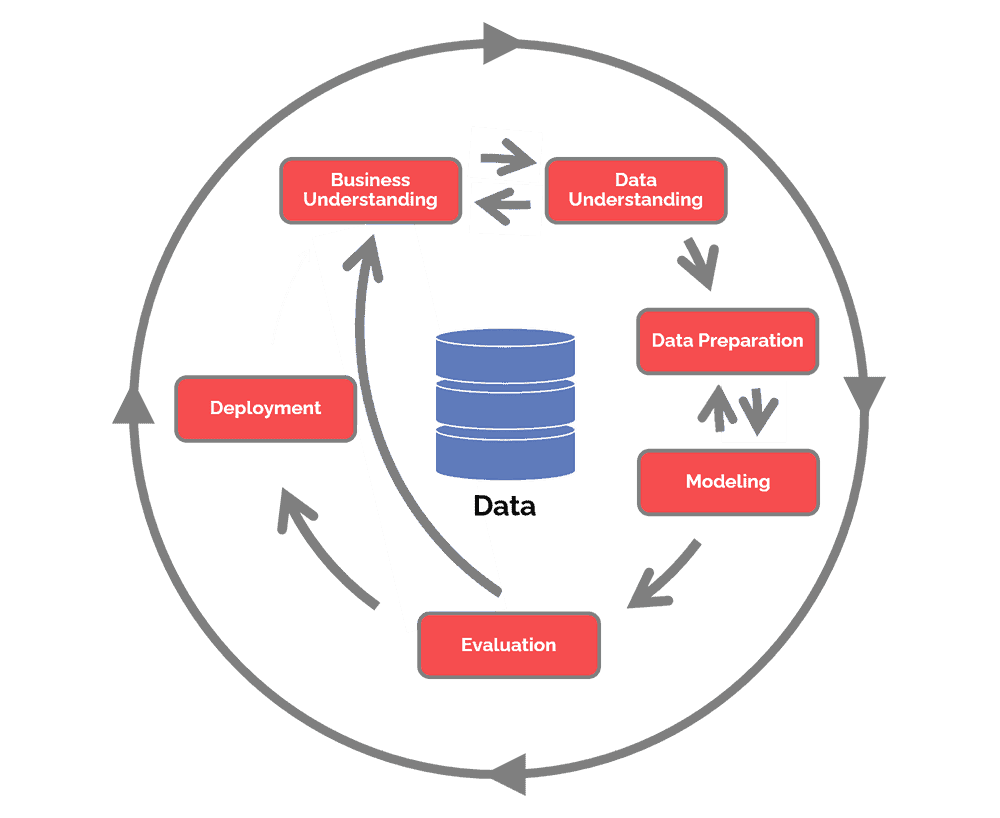

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle


In [ ]:
# Copy the “kaggle.json” into this new directory
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# Ready to download the data
! kaggle competitions download lish-moa

 87% 56.0M/64.7M [00:00<00:00, 136MB/s] 
100% 64.7M/64.7M [00:00<00:00, 108MB/s]


In [ ]:
# Unzip the loaded data
!unzip lish-moa

Archive:  lish-moa.zip
  inflating: sample_submission.csv   
  inflating: test_features.csv       
  inflating: train_drug.csv          
  inflating: train_features.csv      
  inflating: train_targets_nonscored.csv  
  inflating: train_targets_scored.csv  


**Features**
* sig_id is the unique sample id
* Features with g- prefix are gene expression features and there are 772 of    
them (from g-0 to g-771)
* Features with c- prefix are cell viability features and there are 100 of them
(from c-0 to c-99)
* cp_type is a binary categorical feature which indicates the samples are
treated with a compound or with a control perturbation (trt_cp or ctl_vehicle)
* cp_time is a categorical feature which indicates the treatment duration(24, 48 or 72 hours)
* cp_dose is a binary categorical feature which indicates the dose is low or high (D1 or D2)




**Target Dataset consits of:**

**inhibitor** - inhibitor is a substance that slows or blocks the action of an enzyme

**antagonist** - antagonist is a substance that stops the effect of another substance

**agonist** - agonist is a substance that mimics the actions of a hormone or neurotransmitter, and produces a response when it binds to a receptor in the brain.

**1. Importing all necessary python modules**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
import datetime
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

**2. Reading Datasets**

In [ ]:
 # Reading train dataset
train = pd.read_csv("train_features.csv")
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [ ]:
 # Reading test dataset
test = pd.read_csv("test_features.csv")
test.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.1430,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.0310,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.3840,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942
3,id_00276f245,trt_cp,24,D2,0.4828,0.1955,0.3825,0.4244,-0.5855,-1.2020,...,0.1260,0.1570,-0.1784,-1.1200,-0.4325,-0.9005,0.8131,-0.1305,0.5645,-0.5809
4,id_0027f1083,trt_cp,48,D1,-0.3979,-1.2680,1.9130,0.2057,-0.5864,-0.0166,...,0.4965,0.7578,-0.1580,1.0510,0.5742,1.0900,-0.2962,-0.5313,0.9931,1.8380


In [ ]:
#Reading target variable columns
target = pd.read_csv("train_targets_scored.csv")
target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**2.1 Analyzing Datasets**

In [ ]:
train.shape

(23814, 876)

In [ ]:
test.shape

(3982, 876)

In [ ]:
target.shape

(23814, 207)

In [ ]:
train.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [ ]:
train.dtypes.value_counts()

float64    872
object       3
int64        1
Name: count, dtype: int64

**Finding categorical variables in the dataset**

In [ ]:
for col in train.columns:
  if train[col].dtype == "object":
    print(col)

sig_id
cp_type
cp_dose


In [ ]:
#Number of features with type gene expression
gene_exp = sum(train.columns.str.startswith('g-'))
gene_exp

772

In [ ]:
#Number of features with type cell viability
cell_via = sum(train.columns.str.startswith('c-'))
cell_via

100

**Visualizing Gene and Cell types**

**Gene Expression Features**

*   Gene expression is the amount and type of proteins that are expressed in a cell at any given point in
 time.
*    There are 772 gene expression features and they have g- prefix (g-0 to g-771). Each gene
 expression feature represents the expression of one particular gene, so there are 772 individual
 genes are being monitored in this assay



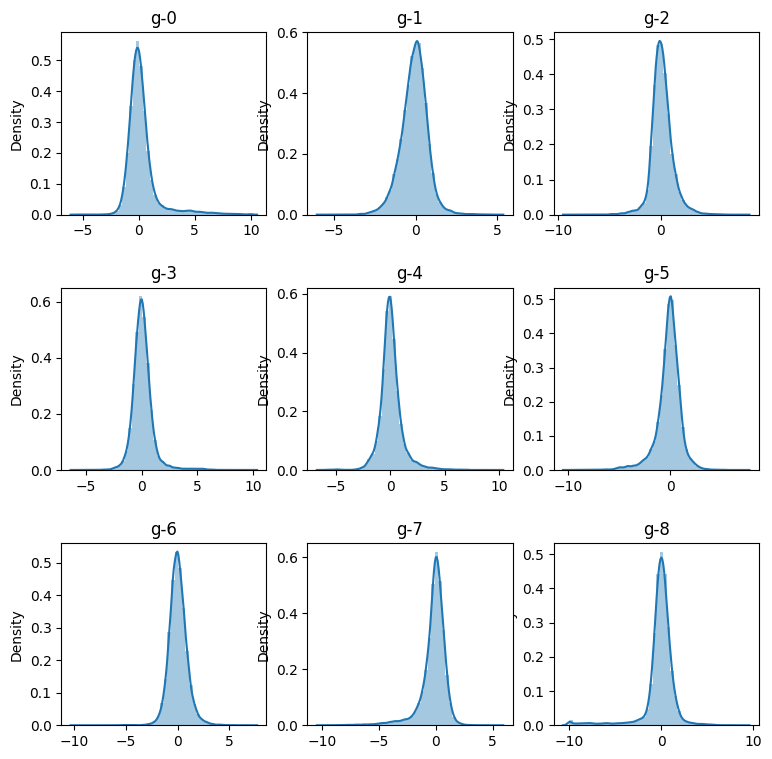

In [ ]:
plt.figure(figsize=(9,9))
plt.subplot(3,3,9)
for i in range(9):
  plt.subplot(3,3,i+1)
  sns.distplot(train.iloc[:,i+4])
  plt.title(train.columns[i+4])
  plt.xlabel('')

plt.subplots_adjust(hspace=0.4)
plt.show()

**Cell Viability Features**

* Cell viability is a measure of the proportion of live, healthy cells within a population. Cell viability assays are used to determine the overall health of cells, optimize culture or experimental conditions.

* There are 100 cell-viability features and they have c- prefix (c-0 to c-99). Each cell-viability feature represents viability of one particular cell line, and all experiments are based on a set of similar cells

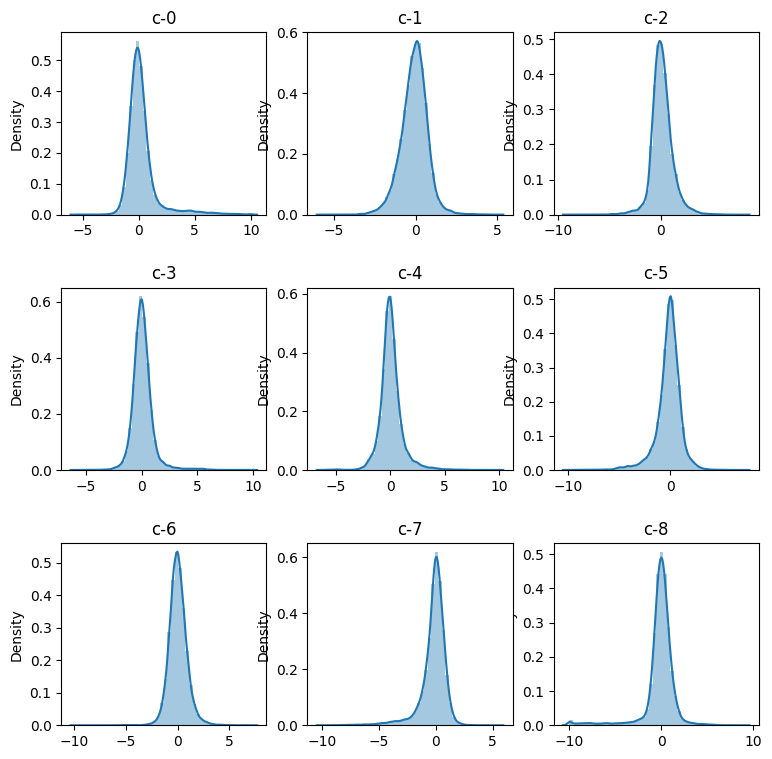

In [ ]:
plt.figure(figsize=(9,9))
plt.subplot(3,3,9)
for i in range(9):
  plt.subplot(3,3,i+1)
  sns.distplot(train.iloc[:,i+4])
  plt.title(train.columns[i+776])
  plt.xlabel('')

plt.subplots_adjust(hspace=0.4)
plt.show()

**Categorical Features**


*  There are three categorical features; cp_type, cp_time and cp_dose. Two of them are binaryfeatures and one of them has three unique values, so the cardinality among those features, is very low. All of the categorical features have almost identical distributions in training set.



In [ ]:
#Check on categorical variables
train['cp_type'].value_counts()

cp_type
trt_cp         21948
ctl_vehicle     1866
Name: count, dtype: int64

In [ ]:
train.cp_time.unique() #that means 24 hrs or 48 hrs or 72 hrs

array([24, 72, 48])

<Axes: xlabel='cp_time'>

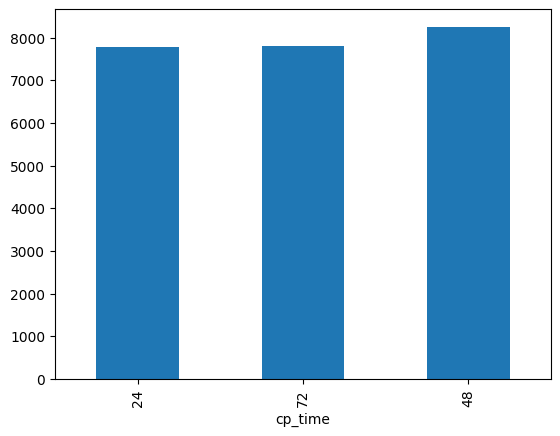

In [ ]:
train['cp_time'].value_counts().sort_values().plot(kind = 'bar')

**cp_time**

*   cp_time is categorical feature in the dataset and it has three unique values; 24, 48 and 72 hours. It
indicates the treatment durations of the samples. Sample counts of different cp_time values are very
consistent and close to each other in different targets. Sample counts are either extremely close to
each other or 48 is slightly higher than the others



<Axes: >

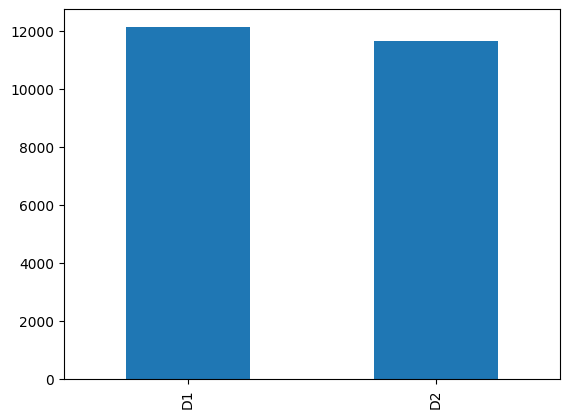

In [ ]:
train['cp_dose'].value_counts().plot(kind = 'bar')

 **cp_dose**

*   cp_dose is categorical feature in the dataset and it is also a binary feature. It indicates whether the
dose of the samples are either low (D1) or high (D2)





<Axes: >

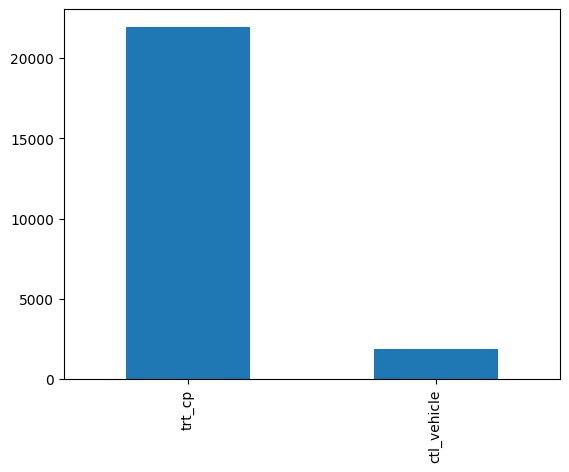

In [ ]:
train['cp_type'].value_counts().plot(kind = 'bar')

**cp_type**
* cp_type is categorical feature in the dataset and it is a binary feature. It either means that samples
 are treated with a compound (trt_cp) or with a control perturbation (ctl_vehicle). Samples treated
 with control perturbations have no MoAs, thus all of their scored and non-scored target labels are
 zeros.

**Treating Categorical variables for Train and Test Data**

In [ ]:
train = pd.get_dummies(train, columns = ['cp_time'], drop_first=True)
test = pd.get_dummies(test, columns = ['cp_time'], drop_first=True)

In [ ]:
train = pd.get_dummies(train, columns = ['cp_dose'], drop_first=True)
test = pd.get_dummies(test, columns = ['cp_dose'], drop_first=True)

In [ ]:
train = pd.get_dummies(train, columns = ['cp_type'], drop_first=True)
test = pd.get_dummies(test, columns = ['cp_type'], drop_first=True)

In [ ]:
train.head()

,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-94,c-95,c-96,c-97,c-98,c-99,cp_time_48,cp_time_72,cp_dose_D2,cp_type_trt_cp
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,False,False,False,True
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,False,True,False,True
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,True,False,False,True
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,True,False,False,True
4,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,...,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,False,True,True,True


**Understanding Target Variables**

*   Target features are categorized into two groups; scored and non-scored target features, and
features in both of those groups are binary. The competition score is based on the scored target
features but non-scored group can still be used for model evaluation, data analysis and feature
engineering.
*   It is a multi-label classification problem but one sample can be classified to multiple targets or none
of the targets as well. Most of the time, samples are classified to 0 or 1 target, but a small part of the
training set samples are classified to 2, 3, 4, 5 and 7 different targets at the same time. Classified
targets distributions are not very similar for scored targets and non-scored targets since there is a
huge discrepancy of 0 and 1 classified targets.



In [ ]:
#plt.figure(figsize=(10, 10))
#label_counts = target.iloc[:, 1:].sum(axis=1)  # Calculate the sum of labels for each sample

# Plotting the count plot
#sns.countplot(label_counts)
#plt.title("Multi Label Distribution in Target Variables", fontsize=16)
#plt.xlabel("Label Count", fontsize=12)
#plt.ylabel("Frequency", fontsize=12)  # Adding a label for the y-axis

#plt.show()

All the target columns are binary in nature, indicating whether a cell type responds to the
drug or not. Since, this is a multi-label classification problem drug samples can have multiple
MoA i.e. more than one target variable class can be active. We draw the bar plot to show
multi label distribution in target variables.


*   Scored Target Features
*   The most commmonly classified scored targets are nfkb inhibitor, proteasome inhibitor,
cyclooxygenase inhibitor, dopamine receptor antagonist, serotonin receptor antagonist and
dna_inhibitor, and there are more than 400 samples classified to each of them. The most rarely
classified scored targets are atp-sensitive potassium channel antagonist and erbb2 inhibitor, and
there is only one sample classified to each of them. A similar classification distribution is expected in
test set.
*  There are lots of scored targets classified with the same number of times which suggests there
might be a relationship between them



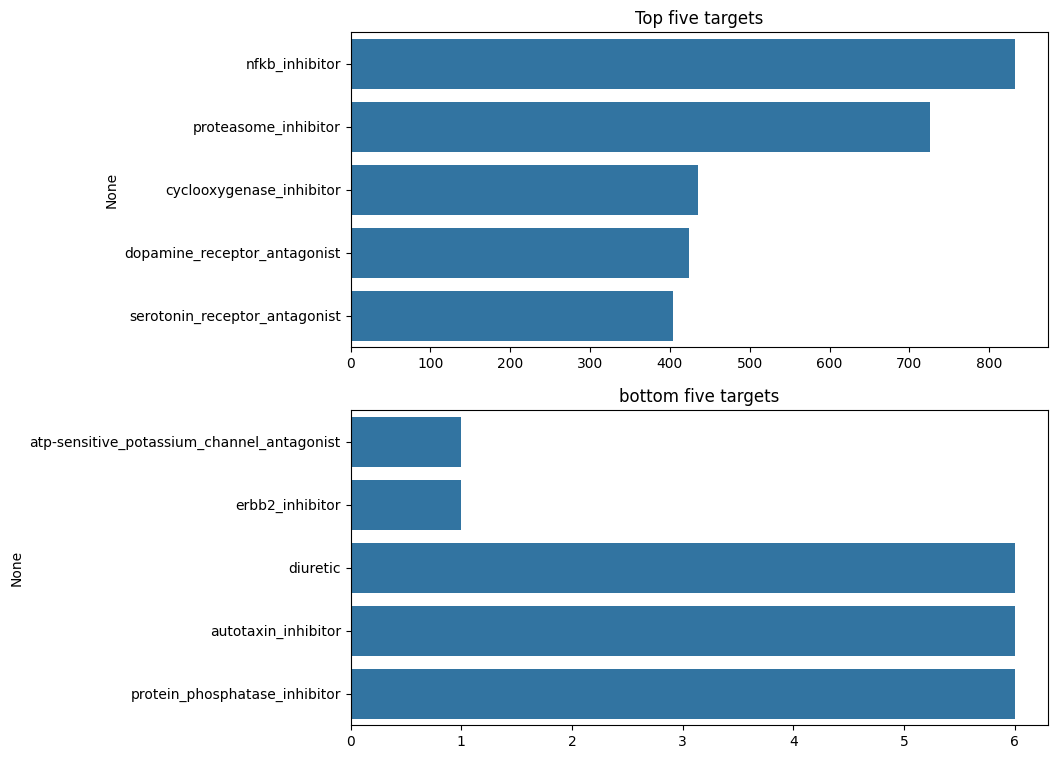

In [ ]:
#Visualising top 5 targets and bottom 5 targets
target1  = target.drop(['sig_id'] , axis =1)
top_targets = pd.Series(target1.sum()).sort_values(ascending=False)[:5]
bottom_targets = pd.Series(target1.sum()).sort_values()[:5]
fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
sns.barplot(x=top_targets.values , y=top_targets.index , ax = axs[0] ).set(title = "Top five targets")
sns.barplot(x=bottom_targets.values , y=bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
plt.show()


**Cleaning Data**


In [ ]:
train.columns[train.isnull().any()]

Index([], dtype='object')

In [ ]:
test.columns[test.isnull().any()]

Index([], dtype='object')

**Merging target into single column**

In [ ]:
target_subset = target.iloc[:, 1:]
target['total_cells_reacted'] = target_subset.sum(axis=1)

target['cell_reaction'] = np.minimum(1,target['total_cells_reacted'])

In [ ]:
target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,total_cells_reacted,cell_reaction
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,1
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


**Defining the target variable**

In [ ]:
# cell reaction as target
target['cell_reaction'].value_counts()

cell_reaction
1    14447
0     9367
Name: count, dtype: int64

**t-test to check on all features and check if p-value < (0.05)**

* The null hypothesis states that there is no relationship between the two variables being studied (one variable does not affect the other).
* The alternative hypothesis states that the independent variable did affect the dependent variable.

**How do you know if a p-value is statistically significant?**
* The level of statistical significance is often expressed as a p-value between 0 and 1. The smaller the p-value, the stronger the evidence that we should reject the null hypothesis.
* A p-value less than 0.05 (typically ≤ 0.05) is statistically significant. It indicates strong evidence against the null hypothesis, Therefore, we reject the null hypothesis, and accept the alternative hypothesis.

In [ ]:
count = 0
x =[]
for col in train.columns:
    if col in ['sig_id', 'cp_type', 'cp_time', 'cp_dose']:
        continue
    if stats.ttest_ind(train[col], test[col]).pvalue < 0.05:
        print(col, stats.ttest_ind(train[col], test[col]).pvalue)
        x.append(col)
        count += 1

g-0 0.032543038217202086
g-1 0.019393109454476025
g-3 0.046721309178349664
g-22 6.587624616736739e-05
g-37 0.01091104029279924
g-48 0.030801708455925808
g-50 0.03531252898048682
g-52 0.028092336066332588
g-60 0.003985876456805001
g-72 0.03734120596180097
g-98 0.002596791303651995
g-100 0.008351686077946879
g-101 3.938347554051903e-05
g-105 0.0429096270660344
g-110 0.007002341005554218
g-119 0.0026784043039369777
g-120 0.04036243989718826
g-121 0.018277391157227284
g-134 0.024952122240263698
g-135 5.2762961694835956e-05
g-136 0.014781889784802743
g-139 0.032409758453034926
g-140 0.029888796018104586
g-145 0.04082269273028868
g-150 0.027419170102437437
g-152 0.02954049101194622
g-158 0.006359327029617653
g-165 0.015874095698013277
g-166 0.044642334463927895
g-168 0.042022254558564405
g-169 0.03499856643946845
g-174 0.018682872175197398
g-186 0.008947447524514195
g-193 0.027903058327269626
g-206 0.03192430403626618
g-211 0.0011897547708701196
g-215 0.023199568324813253
g-224 0.03730567820

In [ ]:
count

124

**As the above listed 124 features have p-value < 0.05, hence we can say that those features are highly dependent on target variable.**

**Data Modeling**

In [ ]:
train_target = train.merge(target[['sig_id','cell_reaction']],  on='sig_id', how='inner')

In [ ]:
train_target.head()

,sig_id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-95,c-96,c-97,c-98,c-99,cp_time_48,cp_time_72,cp_dose_D2,cp_type_trt_cp,cell_reaction
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,...,0.6584,-0.3981,0.2139,0.3801,0.4176,False,False,False,True,1
1,id_000779bfc,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,...,0.4899,0.1522,0.1241,0.6077,0.7371,False,True,False,True,0
2,id_000a6266a,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,...,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,True,False,False,True,1
3,id_0015fd391,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,...,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,True,False,False,True,0
4,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,...,-0.3031,0.1094,0.2885,-0.3786,0.7125,False,True,True,True,1


In [ ]:
# Defining input and target columns
X = train_target.drop(['sig_id','cell_reaction'],axis=1)
y = train_target['cell_reaction']

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle= True)

**Performing LogRegression and RandomForestClassifier using KFold method**

In [ ]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''

    dfs = []
    models = [
              ('LogReg', LogisticRegression()),
              ('RF', RandomForestClassifier()),
              ('GB',GradientBoostingClassifier()),
              ('GNB',GaussianNB())

            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    #target_names = ['malware', 'clean']
    for name, model in models:
        kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    final = pd.concat(dfs, ignore_index=True)
    return final

**CLassification Report and Accuracy Report**

In [ ]:
final = run_exps(X_train, y_train, X_test, y_test)

LogReg
              precision    recall  f1-score   support

           0       0.62      0.39      0.48      1809
           1       0.70      0.85      0.77      2954

    accuracy                           0.68      4763
   macro avg       0.66      0.62      0.62      4763
weighted avg       0.67      0.68      0.66      4763

RF
              precision    recall  f1-score   support

           0       0.73      0.28      0.41      1809
           1       0.68      0.94      0.79      2954

    accuracy                           0.69      4763
   macro avg       0.70      0.61      0.60      4763
weighted avg       0.70      0.69      0.64      4763

GB
              precision    recall  f1-score   support

           0       0.93      0.23      0.37      1809
           1       0.68      0.99      0.80      2954

    accuracy                           0.70      4763
   macro avg       0.80      0.61      0.59      4763
weighted avg       0.77      0.70      0.64      4763

GNB
  

In [ ]:
final

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,3.614765,0.269219,0.661313,0.653424,0.661313,0.646720,0.700991,LogReg
1,2.922691,0.285204,0.657795,0.647870,0.657795,0.642544,0.698352,LogReg
2,3.498418,0.225130,0.660157,0.649280,0.660157,0.645014,0.691204,LogReg
3,60.728604,0.912249,0.671233,0.689280,0.671233,0.627911,0.670450,RF
4,61.020228,0.626691,0.679370,0.695433,0.679370,0.637560,0.690035,RF
5,59.826695,0.821671,0.674173,0.685765,0.674173,0.628662,0.669890,RF
6,494.408902,0.176230,0.688868,0.771072,0.688868,0.628944,0.704596,GB
7,473.778651,0.179949,0.689764,0.759246,0.689764,0.630428,0.704715,GB
8,485.180650,0.169445,0.688346,0.761017,0.688346,0.624298,0.688188,GB
9,0.363873,0.324097,0.479924,0.635687,0.479924,0.412864,0.667461,GNB


**XGBoost Classifier**

In [ ]:
# Initialize XGBoost classifier
xgb_classifier = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Train the classifier
xgb_classifier.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.41      0.48      1809
           1       0.70      0.83      0.76      2954

    accuracy                           0.67      4763
   macro avg       0.64      0.62      0.62      4763
weighted avg       0.66      0.67      0.65      4763



**Performing AdaBoost**

In [ ]:
adabclass = AdaBoostClassifier(n_estimators=100,learning_rate = 0.01, random_state=42)
adabclass.fit(X_train,y_train)
y_predict =adabclass.predict(X_test)
confusion_matrix(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       1.00      0.19      0.33      1809
           1       0.67      1.00      0.80      2954

    accuracy                           0.69      4763
   macro avg       0.83      0.60      0.56      4763
weighted avg       0.80      0.69      0.62      4763



**LightGBM**

In [ ]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',  # Use binary_logloss for binary classification
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Convert dataset into LightGBM format
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train the LightGBM model
num_round = 1000  # Number of boosting rounds
bst = lgb.train(params, lgb_train, num_round, valid_sets=[lgb_eval])

# Make predictions on the testing set
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

# Convert probabilities to binary predictions (assuming binary classification)
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

# Evaluate the model
print(classification_report(y_test, y_pred_binary))

              precision    recall  f1-score   support

           0       0.70      0.34      0.45      1809
           1       0.69      0.91      0.79      2954

    accuracy                           0.69      4763
   macro avg       0.69      0.62      0.62      4763
weighted avg       0.69      0.69      0.66      4763



**Tunning the model**
**Using RandomForestClassifier by changinng n_estimator,max_features and other parameters**

In [ ]:
random_forest = RandomForestClassifier(n_estimators = 200,oob_score = True,n_jobs = -1, min_samples_leaf =4)
#Train Model
random_forest.fit(X_train, y_train)
# Predict Model
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.26      0.40      1894
           1       0.66      0.97      0.79      2869

    accuracy                           0.69      4763
   macro avg       0.77      0.62      0.59      4763
weighted avg       0.75      0.69      0.63      4763



In [ ]:
random_forest = RandomForestClassifier(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50,max_features = "auto", min_samples_leaf = 50)
#Train Model
random_forest.fit(X_train, y_train)
# Predict Model
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.23      0.37      1894
           1       0.66      0.98      0.79      2869

    accuracy                           0.68      4763
   macro avg       0.77      0.61      0.58      4763
weighted avg       0.75      0.68      0.62      4763



In [ ]:
random_forest = RandomForestClassifier(n_estimators = 300, oob_score = True, n_jobs = -1,random_state =50,max_features = "auto", min_samples_leaf = 20)
#Train Model
random_forest.fit(X_train, y_train)
# Predict Model
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.23      0.37      1894
           1       0.66      0.99      0.79      2869

    accuracy                           0.69      4763
   macro avg       0.79      0.61      0.58      4763
weighted avg       0.76      0.69      0.62      4763



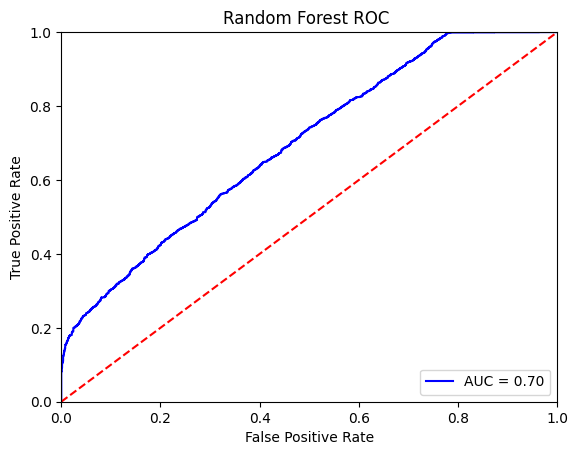

In [ ]:
#Plotting ROC
probs = random_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Random Forest ROC ')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**Using GradientBoostingClassifier to fine tune the model by changing learning_rate and other parameters**

In [ ]:
gbclass = GradientBoostingClassifier(random_state =0)
gbclass.fit(X_train,y_train)
y_predict = gbclass.predict(X_test)
confusion_matrix(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.93      0.23      0.37      1809
           1       0.68      0.99      0.80      2954

    accuracy                           0.70      4763
   macro avg       0.80      0.61      0.59      4763
weighted avg       0.77      0.70      0.64      4763



In [ ]:
%%time
gbclass = GradientBoostingClassifier(random_state =0, learning_rate = 0.01,n_estimators=500
                                     ,max_depth=6,min_samples_split = 10 )
gbclass.fit(X_train,y_train)
y_predict = gbclass.predict(X_test)
confusion_matrix(y_test,y_predict)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.94      0.23      0.37      1809
           1       0.68      0.99      0.80      2954

    accuracy                           0.70      4763
   macro avg       0.81      0.61      0.59      4763
weighted avg       0.78      0.70      0.64      4763

CPU times: user 1h 54min 11s, sys: 6.05 s, total: 1h 54min 17s
Wall time: 1h 55min 20s


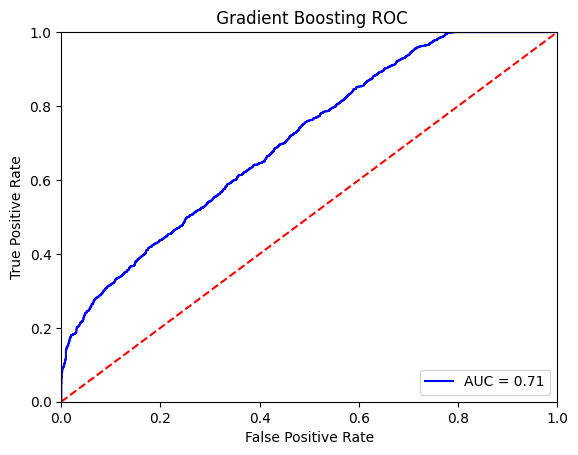

In [ ]:
#Plotting ROC
probs = gbclass.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title(' Gradient Boosting ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, preds)

**Defining Target column as Total number of cells reacted**

In [ ]:
X = train.drop(['sig_id'],axis=1)
y = target['total_cells_reacted']

**Classifying Target**

<Axes: xlabel='cyclooxygenase_inhibitor'>

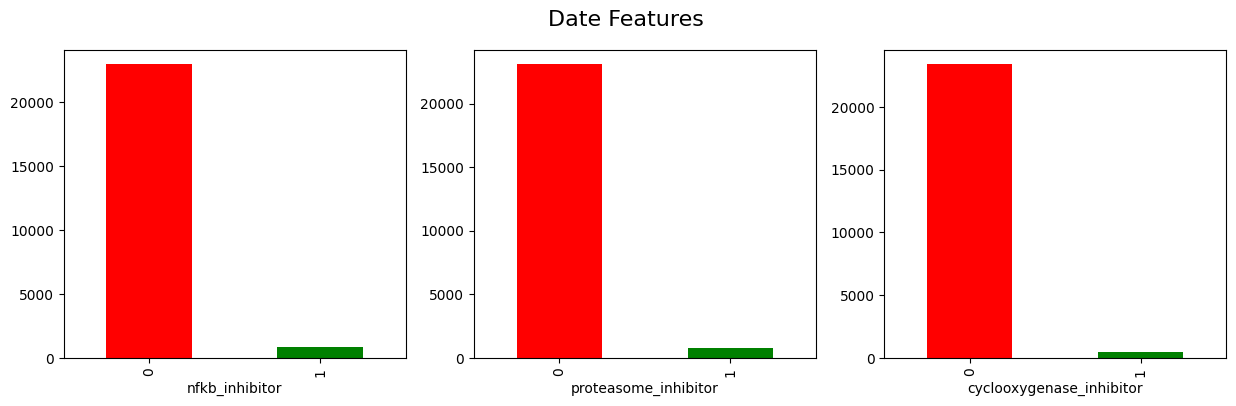

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4),sharex =False)
fig.suptitle("Date Features", fontsize=16)

fig.set_figwidth(15)
# fig.set_figheight(10)

target['nfkb_inhibitor'].value_counts().plot(kind='bar', ax=axes[0],color=list('rgbkymc'))
target['proteasome_inhibitor'].value_counts().plot(kind='bar', ax=axes[1],color =list('rg'))
target['cyclooxygenase_inhibitor'].value_counts().plot(kind='bar', ax=axes[2],color=list('rg'))
#df['ReportTime_month'].value_counts().plot(kind='bar', ax=axes[3],color =list('gr'))

In [ ]:
target['total_cells_reacted'].value_counts()

total_cells_reacted
1    12532
0     9367
2     1538
3      303
4       55
5       13
7        6
Name: count, dtype: int64

In [ ]:
x = target.drop(['sig_id'], axis=1).sum(axis=0).sort_values(ascending= False).reset_index()

In [ ]:
cols = target.columns
def get_classname(row):
    for col in cols:
        if(row[col] == 1 and col != 'sig_id'):
            return col
    return "No_cells_reacted"

target['final_col'] = target.apply(get_classname,axis=1)

In [ ]:
target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,total_cells_reacted,cell_reaction,final_col
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,gsk_inhibitor
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,No_cells_reacted
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1,bcr-abl_inhibitor
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,No_cells_reacted
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,calcium_channel_blocker


In [ ]:
target['final_col'].value_counts()

final_col
No_cells_reacted                              9367
nfkb_inhibitor                                 796
cyclooxygenase_inhibitor                       423
dopamine_receptor_antagonist                   418
dna_inhibitor                                  384
                                              ... 
caspase_activator                                6
laxative                                         6
retinoid_receptor_antagonist                     6
diuretic                                         6
atp-sensitive_potassium_channel_antagonist       1
Name: count, Length: 205, dtype: int64

**inhibitor** - inhibitor is a substance that slows or blocks the action of an enzyme

**antagonist** - antagonist is a substance that stops the effect of another substance

**agonist** - agonist is a substance that mimics the actions of a hormone or neurotransmitter, and produces a response when it binds to a receptor in the brain.

In [ ]:
inhib = "inhibitor"
antag = "antagonist"
agon = "agonist"

def get_classtypes(col):
    if inhib in col.lower():
        return inhib
    if antag in col.lower():
        return antag
    if agon in col.lower():
        return agon
    if col == "No_cells_reacted":
        return "No_cells_reacted"
    return "Other"

target['cell_type'] = target['final_col'].apply(get_classtypes)

In [ ]:
target['cell_type'].value_counts()

cell_type
No_cells_reacted    9367
inhibitor           7756
antagonist          3261
agonist             2118
Other               1312
Name: count, dtype: int64

In [ ]:
target['MoA_classtype'] = pd.factorize(target['cell_type'])[0]

In [ ]:
target.head(20)

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,total_cells_reacted,cell_reaction,final_col,cell_type,MoA_classtype
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,gsk_inhibitor,inhibitor,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No_cells_reacted,No_cells_reacted,1
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,1,bcr-abl_inhibitor,inhibitor,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No_cells_reacted,No_cells_reacted,1
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,calcium_channel_blocker,Other,2
5,id_001762a82,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,gsk_inhibitor,inhibitor,0
6,id_001bd861f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No_cells_reacted,No_cells_reacted,1
7,id_0020d0484,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,cdk_inhibitor,inhibitor,0
8,id_00224bf20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,No_cells_reacted,No_cells_reacted,1
9,id_0023f063e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,pdk_inhibitor,inhibitor,0


In [ ]:
target['MoA_classtype'].value_counts()

MoA_classtype
1    9367
0    7756
3    3261
4    2118
2    1312
Name: count, dtype: int64

In [ ]:
X = train.drop(['sig_id'],axis=1)
y = target['MoA_classtype']

In [ ]:
y_test

12981    0
4290     0
11666    0
1056     1
423      1
        ..
13198    0
2312     0
14379    1
13640    1
18932    0
Name: cell_reaction, Length: 4763, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41,shuffle= True)

In [ ]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''

    dfs = []
    models = [

              ('RF', RandomForestClassifier(n_estimators=10)),
              ('RF_1', RandomForestClassifier(n_estimators=100)),
              ('RF_2', RandomForestClassifier(n_estimators=500)),
              ('GB',GradientBoostingClassifier(n_estimators=10))


            ]
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    #target_names = ['malware', 'clean']
    for name, model in models:
        #kfold = model_selection.KFold(n_splits=3, shuffle=True, random_state=90210)
        #cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        #print(log_loss(y_test,y_pred))

        print(100*(y_test == y_pred).sum()/X_test.shape[0])
#        print(classification_report(y_test, y_pred))
#         results.append(cv_results)
#         names.append(name)
#         this_df = pd.DataFrame(cv_results)
#         this_df['model'] = name
#         dfs.append(this_df)
#    final = pd.concat(dfs, ignore_index=True)
    return final

In [ ]:
final = run_exps(X_train, y_train, X_test, y_test)

RF
48.22590804115053
RF_1
52.11001469661978
RF_2
53.28574427881587
GB
51.92105815662398


In [ ]:
model = RandomForestClassifier(n_estimators=10)
clf = model.fit(X_train, y_train)
y_pred = clf.predict_proba(X_test)

In [ ]:
y_pred

array([[1. , 0. , 0. , 0. , 0. ],
       [0.1, 0.6, 0. , 0.1, 0.2],
       [0.6, 0.1, 0. , 0.2, 0.1],
       ...,
       [0.2, 0.6, 0.1, 0.1, 0. ],
       [0.1, 0.4, 0.1, 0.3, 0.1],
       [1. , 0. , 0. , 0. , 0. ]])

In [ ]:
y_pred1 = clf.predict(X_test)

In [ ]:
y_pred1

array([0, 1, 0, ..., 1, 1, 0])

In [ ]:
np.unique(y_pred1)

array([0, 1, 2, 3, 4])

In [ ]:
X_test['y'] = y_test
X_test['y_pred'] = y_pred1

In [ ]:
X_test[['y','y_pred']]

,y,y_pred
19549,0,0
17824,2,1
6955,3,0
7521,0,1
15611,3,1
...,...,...
47,1,1
16766,0,3
15753,0,1
20011,1,1


In [ ]:
100*(y_test == y_pred1).sum()/X_test.shape[0]

46.44131849674575

In [ ]:
y_pred

array([[1. , 0. , 0. , 0. , 0. ],
       [0.1, 0.6, 0. , 0.1, 0.2],
       [0.6, 0.1, 0. , 0.2, 0.1],
       ...,
       [0.2, 0.6, 0.1, 0.1, 0. ],
       [0.1, 0.4, 0.1, 0.3, 0.1],
       [1. , 0. , 0. , 0. , 0. ]])

In [ ]:
test_features = pd.read_csv('/content/test_features.csv')
test_features = test_features.drop(['sig_id'],axis=1)
# p_min = 0.0005
# p_max = 0.9995

# Generate submission file, Clip Predictions

sub = pd.read_csv('/content/sample_submission.csv')
# sub.iloc[:,1:] = np.clip(y_pred,p_min,p_max)

# Set ctl_vehicle to 0
sub.iloc[test_features['cp_type'] == 'ctl_vehicle',1:] = 0

# Save Submission
sub.to_csv('/content/submission.csv', index=False)

In [ ]:
#submission=pd.read_csv('/content/submission.csv')
#submission.head()